In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
import pandas as pd
from ipywidgets import interact
from ipywidgets import widgets as w

/home/woejozney/miniconda3/envs/ds/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Simulation Tests

As the first validation test, we should be able to generate data that resembles the real data according to a data generating proccess we want to use to analyze the data. And in that case, if we can create realistic data and then add a known intervention, can we recover the effects of the intervention using the specified model? If this plays out okay, we can consider ourselves of having chosen a suitable model model looking at the problem. 

In this case, a state space model, structural time series, whatever you want to call it. Most all other time series model can be written in state space form or have state space equivalents. The advantage of SMM being that it does not depend on differencing. I went ahead and made several functions, building them up as pieces, but for the most part, I'm only using the seasonal ones. Basic structure is:


```
local level:
y[t] = mu[t] + seasonal[t] + observation_error          /// observation equation
mu[t+1] = mu[t] + level_error                          /// unobserved latent level
seasonal[t] = -sum(seasonal[previous remaining seasonal terms in cycle]) + seasonal error /// dummy seasonal plus some stochastic noise

local level trend:
y[t] = mu[t] + seasonal[t] + observation_error      /// observation equation
mu[t+1] = mu[t] + delta[t] + level_error       /// unobserved latent level 
delta[t+1] = delta[t] + delta_error           /// unobserved latent slope
seasonal[t+1] = -sum(seasonal[previous remaining seasonal terms in cycle]) + seasonal error /// dummy seasonal plus some stochastic noise


note: dummies for seasonal cycle add up to 0 plus the error
```

There are plenty of ways to expand on that, such as adding regression components or autoregressive components on the various components.

For the sake of speed, I'm using the unobserved components specification from `statsmodels` which uses a Kalman filter to do the work. https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_local_linear_trend.html
(
All the simulations are stored in a dictionary, and that is what's passed back and forth between many functions. model['y'] or model['y_new'], etc.

All `s_*` variables are scale variables. Stolen from other people, it was better to generate a standard normal (0,1) vector `*_err` and multiply by the scale, than to just use + N(0, s_*) to generate error terms. I have set defaults for seasonality to a monthly basis. 

Since all our data is seasonal, I've only used the seasonal models, but the rest were there to help me write the code, and save for a later data in case I need non-seasonal ones. If I had the time, it'd be cool to actually make a class and all that, but I'm a lazy Python programmer lol.




In [2]:
def dummy_seasonal(series_len, seasonality, duration=1, seed=None, seeded=False):
    """ 
    Get seasonal effects that sum to 0 over seasonal period
    Assumes N(0,1) distribution
    If you want specific effect, the scale is specified in the code for the simulations
    Called within the local level and local level trend functions
    """
    
    if seeded:
        np.random.seed(seed)

    seas = []
    iterations = math.ceil(series_len / duration)
    init_seas = np.zeros(seasonality)

    init_seas[:-1] = np.random.normal(
        0, 1, seasonality - 1
    )

    init_seas[seasonality - 1] = -1 * np.sum(init_seas) 
    # ^^^^ IDK if this IS cheating, but just generating them and then replacing one so they sum to 0 seems like cheating! 
    # But it fulfills the requirements of a seasonal proccess

    for idx in range(iterations):
        seas += [init_seas[idx % seasonality]] * duration
    seas = np.array(seas[:series_len])
    
    return seas

In [3]:
def plot_local_level(model, size=(7,4)):

    y = model['y']
    mu = model['mu']

    fig, ax = plt.subplots(1, figsize=size)
    ax.plot(y, label='y', color='k', alpha=.6)
    ax.plot(mu, label = 'level', color='darkorange')
    fig.legend()
    plt.tight_layout()

def plot_local_level_seasonal(model, size=(7,4)):

    y = model['y']
    mu = model['mu']
    seasonal = model['seasonal']

    fig, ax = plt.subplots(2, figsize=size)
    ax[0].plot(y, label='y', color='k', alpha=.6)
    ax[0].plot(mu, label = 'level', color='darkorange')
    ax[1].plot(seasonal, label='seasonal', color="navy")
    fig.legend()
    plt.tight_layout()

def plot_level_trend(model, size=(7,4)):

    y = model['y']
    mu = model['mu']
    delta = model['delta']

    fig, ax = plt.subplots(2, figsize=size)
    ax[0].plot(y, label='y', color='k', alpha=.6)
    ax[0].plot(mu, label = 'level', color='darkorange')
    ax[1].plot(delta, label="slope", color='k')
    fig.legend()
    plt.tight_layout()

def plot_level_trend_seasonal(model, size=(7,4)):

    y = model['y']
    mu = model['mu']
    delta = model['delta']
    seasonal = model['seasonal']

    fig, ax = plt.subplots(3, figsize=size)
    ax[0].plot(y, label='y', color='k', alpha=.6)
    ax[0].plot(mu, label = 'level', color='darkorange')
    ax[1].plot(delta, label="slope", color='k')
    ax[2].plot(seasonal, label='seasonal', color="navy")
    fig.legend()
    plt.tight_layout()

def plot_intervention_weights(model, size=(10,4)):

    y = model['y_new']
    intervention_weights = model['intervention_weights']

    fig, ax = plt.subplots(2, figsize=size)
    ax[0].plot(y, alpha=1, label="y", color='k', )
    ax[1].plot(intervention_weights, alpha=1, label="intervention weight")
    fig.legend()
    plt.tight_layout()

In [4]:
def local_level(
    num_timesteps=100, 
    init_mu=0, 
    s_obs = 3, 
    s_mu=.1,
    seeded=True, 
    seed=5):

    """ returns dictionary of simulated state space model components"""

    if seeded:
        np.random.seed(seed)
    
    mu = np.zeros(num_timesteps+1)
    y = np.zeros(num_timesteps)
    
    mu_err = np.random.normal(loc=0, scale=1, size=num_timesteps)
    obs_err = np.random.normal(loc=0, scale=1, size=num_timesteps)

    # Get seasonal effects
    mu[0] = init_mu

    for t in range(num_timesteps):
        mu[t+1] = mu[t] + s_mu * mu_err[t]
        y[t] = mu[t] + s_obs * obs_err[t]

    return { 'y':y, 'mu': mu }

In [5]:
def local_level_seasonal(
    num_timesteps=100, 
    init_mu=0, 
    s_obs = 3, 
    s_mu=.1,
    s_seasonal= .01,
    seasonality = 12,
    stochastic_seasonal=True,
    seasonal_factor=1,
    seeded=True, 
    seed=5):

    """ returns dictionary of simulated state space model components"""

    if seeded:
        np.random.seed(seed)
    
    # State and Observation Vectors
    mu = np.zeros(num_timesteps+1)
    y = np.zeros(num_timesteps)
    
    # Error Vectors
    mu_err = np.random.normal(loc=0, scale=1, size=num_timesteps)
    obs_err = np.random.normal(loc=0, scale=1, size=num_timesteps)
    seasonal_err = np.random.normal(loc=0, scale=1, size=num_timesteps)

    # Seasonal Effects
    seasonal = dummy_seasonal(num_timesteps, seasonality, 1, seed=seed, seeded=seeded)
    seasonal = seasonal * seasonal_factor

    # Set Init Values
    mu[0] = init_mu

    for t in range(num_timesteps):
        
        # Level State Equation
        mu[t+1] = mu[t] + s_mu * mu_err[t]

        # Seasonal Equation
        if stochastic_seasonal==True:
            seasonal[t] = seasonal[t] + s_seasonal * seasonal_err[t]
        elif stochastic_seasonal==False:
            seasonal[t] = seasonal[t]
        
        # Observation Equation
        y[t] = mu[t] + seasonal[t] + s_obs * obs_err[t]

    return { 'y': y, 'mu': mu, 'seasonal': seasonal }

In [6]:
def local_level_trend(
    num_timesteps=100, 
    init_mu=0, 
    init_delta=.5,
    s_obs = 2, 
    s_mu=.1, 
    s_delta = .05,
    seeded=True, 
    seed=5,
    stochastic_delta=True
    ):
    
    """ returns dictionary of simulated state space model components"""

    if seeded:
        np.random.seed(seed)
    
    mu = np.zeros(num_timesteps+1)
    delta = np.zeros(num_timesteps+1)
    y = np.zeros(num_timesteps)
    
    mu_err = np.random.normal(loc=0, scale=1, size=num_timesteps)
    obs_err = np.random.normal(loc=0, scale=1, size=num_timesteps)
    delta_err = np.random.normal(loc=0, scale=1, size=num_timesteps)

    # Get seasonal effects
    mu[0] = init_mu
    delta[0] = init_delta

    for t in range(num_timesteps):
        
        # Level State Equation 
        mu[t+1] = mu[t] + delta[t] + s_mu * mu_err[t] 

        # Slope State Equation 
        if stochastic_delta==False: 
            delta[t+1] = delta[t] 
        elif stochastic_delta == True: 
            delta[t+1] = delta[t] + s_delta * delta_err[t] 

        # Observation Equation 
        y[t] = mu[t] + s_obs * obs_err[t] 

    return { 'y': y, 'mu': mu, 'delta': delta }

In [7]:
def local_level_trend_seasonal(
    num_timesteps=100, 
    init_mu=0, 
    init_delta=.5,
    s_obs = 2, 
    s_mu=.1, 
    s_delta = .05,
    s_seasonal= .01,
    seasonality = 12,
    stochastic_seasonal=True,
    seasonal_factor=1,
    seeded=True, 
    seed=5,
    stochastic_delta=True
    ):

    """ returns dictionary of simulated state space model components"""
    
    if seeded:
        np.random.seed(seed)
    
    mu = np.zeros(num_timesteps+1)
    delta = np.zeros(num_timesteps+1)
    y = np.zeros(num_timesteps)
    
    mu_err = np.random.normal(loc=0, scale=1, size=num_timesteps)
    obs_err = np.random.normal(loc=0, scale=1, size=num_timesteps)
    delta_err = np.random.normal(loc=0, scale=1, size=num_timesteps)
    seasonal_err = np.random.normal(loc=0, scale=1, size=num_timesteps)

    # Seasonal Effects
    seasonal = dummy_seasonal(num_timesteps, seasonality, 1, seed=seed, seeded=seeded)
    seasonal = seasonal * seasonal_factor

    # Get seasonal effects
    mu[0] = init_mu
    delta[0] = init_delta

    for t in range(num_timesteps): 
        
        # Level State Equation 
        mu[t+1] = mu[t] + delta[t] + s_mu * mu_err[t] 

        # Slope State Equation 
        if stochastic_delta==False: 
            delta[t+1] = delta[t] 
        elif stochastic_delta == True: 
            delta[t+1] = delta[t] + s_delta * delta_err[t] 
        
        # Seasonal Equation
        if stochastic_seasonal==False:
            seasonal[t] = seasonal[t]
        elif stochastic_seasonal==True:
            seasonal[t] = seasonal[t] + s_seasonal * seasonal_err[t]
        
        # Observation Equation
        y[t] = mu[t] + seasonal[t] + s_obs * obs_err[t]

    return { 'y': y, 'mu': mu, 'delta': delta ,'seasonal': seasonal} 

In [8]:
def compare_components(sim, results, size=(10,6)):
    """ compare orginal simulated dataset to modeled seaosnal component """

    num_comp = len(sim.keys())

    fig, ax = plt.subplots(num_comp, figsize=size)
    ax[0].plot(results.seasonal.smoothed, label='modeled seasonal')
    ax[0].plot(sim['seasonal'], label='ground-truth seasonal')
    ax[0].legend()

    ax[1].plot(results.level.smoothed, label='modeled smoothed level')
    ax[1].plot(results.level.filtered, label='modeled filtered level')
    ax[1].plot(sim['mu'], label='ground-truth level')
    ax[1].legend()

    ax[2].plot(results.fittedvalues, label='modeled observations')
    ax[2].plot(sim['y'], label='ground-truth observations')
    ax[2].legend()

    if 'delta' in sim:
        ax[3].plot(results.trend.filtered, label='modeled trend')
        ax[3].plot(sim['delta'], label='ground-truth observations')
        ax[3].legend()

    plt.tight_layout()
    

## Example Simulations

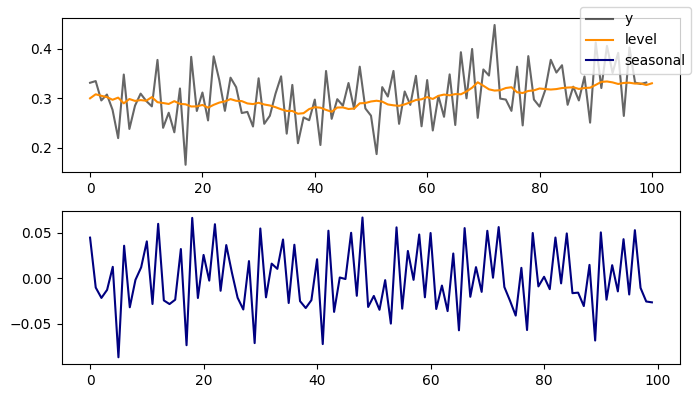

In [9]:
ll = local_level_seasonal(100, init_mu=.30, s_obs=.03, s_mu=.005, seasonality=12, s_seasonal=.01, seasonal_factor=.03, seeded=True, seed=1)
plot_local_level_seasonal(ll)

### Local Level Interactive

Widget

In [10]:

def ll_interact(num_timesteps, init_mu, s_obs, s_mu, seasonality, s_seasonal,
                seasonal_factor,seeded=True, seed=2):
    sim = local_level_seasonal(num_timesteps=num_timesteps, init_mu=init_mu, s_obs=s_obs, s_mu=s_mu, 
                          seasonality=seasonality, s_seasonal=s_seasonal, seasonal_factor=seasonal_factor, seeded=True, seed=seed)
    plot_local_level_seasonal(sim)

interact(ll_interact,
        num_timesteps=w.IntSlider(value=150, min=60, max=200),
        init_mu = w.FloatSlider(value=.1, min=0., max=300.), 
        s_obs= w.FloatSlider(value=.1, min=0., max=10.), 
        s_mu = w.FloatSlider(value=.1, min=0., max=1.), 
        seasonality = w.Dropdown(options=[4, 12],
                            value=12), 
        s_seasonal = w.FloatSlider(value=.1, min=0., max=10.),
        seasonal_factor = w.FloatSlider(value=.1, min=0., max=10.),
        seeded=True, 
        seed=w.IntSlider(value=2, min=1, max=15)
        )


interactive(children=(IntSlider(value=150, description='num_timesteps', max=200, min=60), FloatSlider(value=0.…

<function __main__.ll_interact(num_timesteps, init_mu, s_obs, s_mu, seasonality, s_seasonal, seasonal_factor, seeded=True, seed=2)>

### Fit a model to simulated data

/home/woejozney/miniconda3/envs/ds/lib/python3.10/site-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


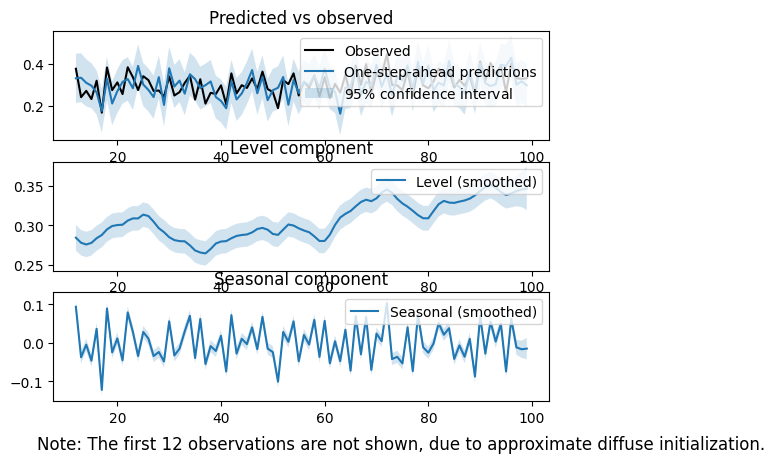

In [11]:
ll = local_level_seasonal(100, init_mu=.30, s_obs=.03, s_mu=.005, seasonality=12, s_seasonal=.01, seasonal_factor=.03, seeded=True, seed=1)
model = sm.tsa.UnobservedComponents(ll['y'], level=True, stochastic_level=True, 
                                    seasonal=12, stochastic_seasonal=True)
results = model.fit(disp=0)
results.summary()
results.plot_components()
plt.show()
plt.close()

### Comparing Simulated versus estimated

Ground truth meaning, the actual simulated components, to compare to what the model thinks the components are. Filtered is based on time points up to T, whereas smoothed is based on whole time series. 

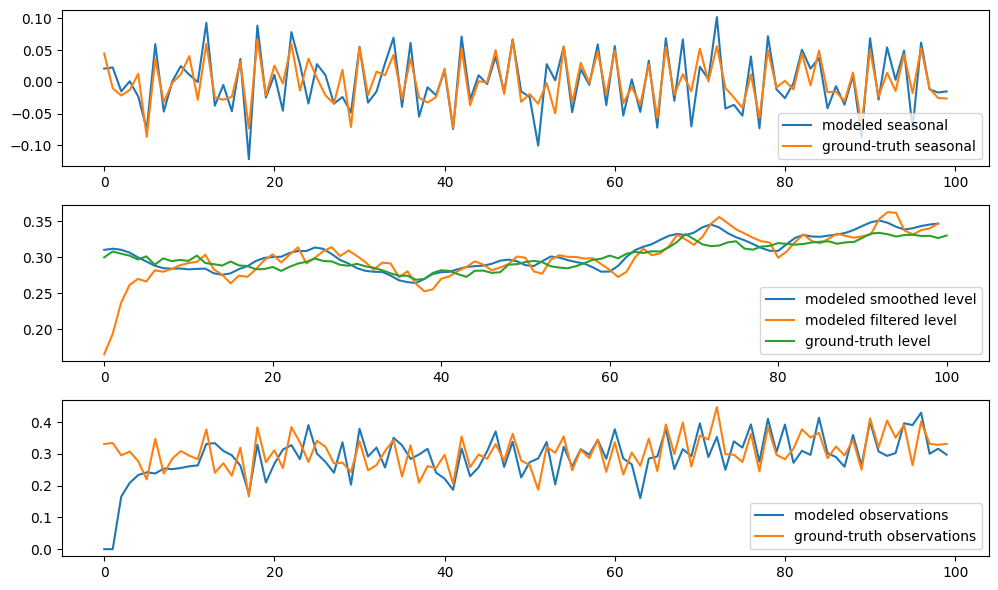

In [12]:
compare_components(ll, results)

### Local Level Trend

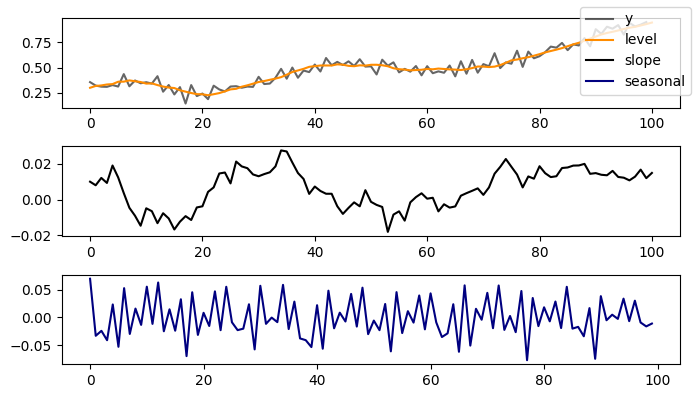

In [13]:
llt = local_level_trend_seasonal(100, init_mu=.30, s_obs=.03, s_mu=.005, s_delta=.005, 
                                 init_delta=.01,  seasonality=12, s_seasonal=.01, 
                                 seasonal_factor=.03, seeded=True, seed=1)
plot_level_trend_seasonal(llt)

### Known Parameters and Model

Can the model recover the paramters within reason?

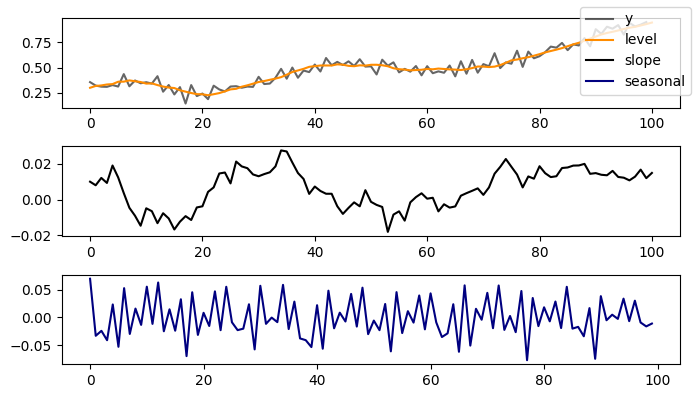

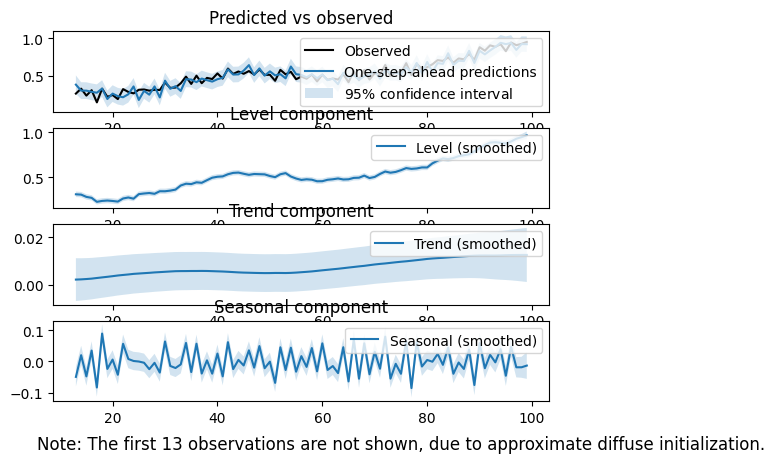

In [14]:
llt = local_level_trend_seasonal(100, init_mu=.30, s_obs=.03, s_mu=.005, s_delta=.005, init_delta=.01,  seasonality=12, s_seasonal=.01, seasonal_factor=.03, seeded=True, seed=1)
plot_level_trend_seasonal(llt)
model = sm.tsa.UnobservedComponents(llt['y'], level=True, stochastic_level=True, trend=True, stochastic_trend=True, 
                                    seasonal=12, stochastic_seasonal=True)
results = model.fit(disp=0)
results.plot_components()
plt.show()
plt.close()

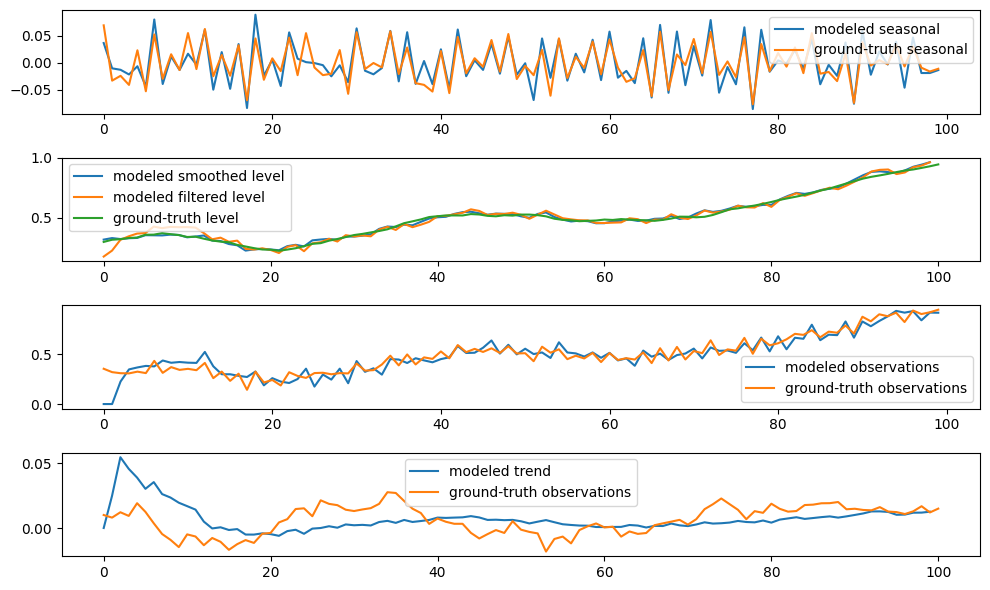

In [15]:
compare_components(llt, results)

### Interactive

## Adding an Intervention

We'll add an intervention and see if the predicted vs observed actually captures the known effect size, or to what level it can detect an effect size, 1 year out, less than 1 year out, etc.. `get_intervention` can make a permanent change or a dip and then return, which is the most like the claims data. After noodling with it, anything below a 10% decrease as the result of an intervention may be dicey. For simplicity's sake, I just add the intervention at the end, although I would like to modify that logic, but I'd rather not break it right now. =P

The `burn_in` variable is because the one-step predictions are kinda crazy for the first one-step-predictions while it's figuring out what is going out, I discard the first year in order to be able to display all the results together. I may have built a house of cards in there with altering the alignment, but it works for now to have it at the end.

I take the "effect" as whatever the value is at the time of observation times some scaling factor, to make a 30% decrease, 10%, whatever.

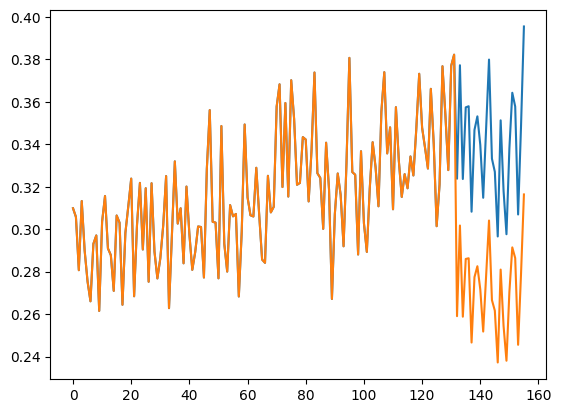

In [37]:
test = get_intervention(ll, intervention_length, effect=-.2)
plt.plot(test['y'])
plt.plot(test['y_new'])

In [45]:
def get_intervention(sim, intervention_length, s_weight=None, effect=-10, impulse='static', decay=None):
    
    """ 
    returns a the simulation dictionary with new_y, an altered y over specified intevention period. 
    Static is a permenant change, return dips down and the speed of recovery is controlled by decay param
    """

    y = sim['y']

    if impulse=='return':
        if decay == 'fast':
            decay_factor=10
        elif decay == 'normal':
            decay_factor=5
        elif decay == 'slow':
            decay_factor==2
        else:
            decay_factor==5
    
    if s_weight == None:
        s_weight = np.var(y) / 10

    num_timesteps = len(y)
    intervention_start = num_timesteps - intervention_length
    intervention_weights = np.zeros(num_timesteps)
    weight_err = np.random.normal(0,1, size=intervention_length)
    effects = y[intervention_start:num_timesteps] * effect

    if impulse=='static':
        intervention_weights[intervention_start:num_timesteps] = effects + s_weight * weight_err
    
    elif impulse=='return':
        #effects = np.array([effects] * intervention_length)
        effects = effects / np.linspace(start=1, stop=decay_factor, num = intervention_length)**2
        intervention_weights[intervention_start:num_timesteps] = effects + s_weight * weight_err
    
    y_new = y + intervention_weights

    sim['y_new'] = y_new
    sim['intervention_weights'] = intervention_weights

    return sim

In [17]:
def get_predictions(results, burn_in, ex=None, forecast_length=24):

    """ returns predictions, both one-step ahead and forecast, and prediction interval for maximum likelihood models"""
    forecast = results.get_forecast(steps=forecast_length)
    one_step = results.get_prediction()
    forecast_df = forecast.summary_frame()
    one_step_df = one_step.summary_frame()

    predict_interval = pd.concat([one_step_df, forecast_df], axis=0)[burn_in:].reset_index()
    predictions = pd.DataFrame({'mean': predict_interval['mean'], 
                                'pred_upper': predict_interval['mean_ci_upper'], 
                                'pred_lower': predict_interval['mean_ci_lower']})

    return predictions



In [18]:
def plot_inference(model, interval, plot_begin, int_begin, burn_in):

    observed = pd.Series(model['y_new'][burn_in:])
    true_diff = pd.Series(abs(model['intervention_weights'][burn_in:]))

    observed = observed.loc[observed.index >= plot_begin]
    interval = interval.loc[interval.index >= plot_begin]
    true_diff = true_diff.loc[true_diff.index >= plot_begin]

    pred_mean = interval['mean']
    pred_upper = interval['pred_upper']
    pred_lower = interval['pred_lower']

    diff_mean =  pred_mean - observed
    diff_upper =  pred_upper - observed
    diff_lower =  pred_lower - observed
    
    new_diff_mean = diff_mean.copy()
    new_diff_upper = diff_upper.copy()
    new_diff_lower = diff_lower.copy()

    new_diff_mean.loc[new_diff_mean.index < int_begin] = 0
    new_diff_upper.loc[new_diff_upper.index < int_begin] = 0
    new_diff_lower.loc[new_diff_lower.index < int_begin] = 0

    cum_diff_mean = new_diff_mean.cumsum()
    cum_diff_upper = new_diff_upper.cumsum()
    cum_diff_lower = new_diff_lower.cumsum()

    fig, ax = plt.subplots(3, 1, figsize = (20, 13))
    ax[0].axvline(int_begin, color='maroon', alpha=.4, linestyle='--')
    ax[0].plot(pred_mean, color='navy', linestyle=(5, (10,3)), label='Predicted Mean', alpha=.7)
    ax[0].fill_between(
        interval.index,
        pred_upper,
        pred_lower,
        alpha=.15,
        label = "Prediction Interval"
    )
    ax[0].plot(observed, color='k', label="Observed", linewidth=2)
    #ax[0].set_ylabel(visit_type + ' ' + outcome, fontsize=16)
    ax[0].set_title('Forecast vs Observed', fontsize=20)
    ax[0].grid(alpha=.1)
    ax[0].legend(loc="upper left", prop={'size': 15})


    ax[1].plot(diff_mean, color='navy', linestyle=(5, (10,3)), label='Predicted Mean Difference', alpha=.7)
    ax[1].plot(true_diff, color='maroon', linestyle=(5, (10,3)), label='Ground Truth Difference', alpha=.6)
   
    ax[1].axvline(int_begin, color='maroon', alpha=.4, linestyle='--')
    ax[1].fill_between(
        interval.index,
        diff_upper,
        diff_lower,
        alpha=.15,
        label = "Prediction Interval"
    )
    ax[1].set_ylabel('Difference', fontsize=16)
    ax[1].set_title('Difference', fontsize=20)
    ax[1].grid(alpha=.1)
    ax[1].legend(loc="upper left", prop={'size': 15})

    ax[2].plot(cum_diff_mean, color='navy', linestyle=(5, (10,3)), label='Predicted Mean Difference', alpha=.7)
    ax[2].axvline(int_begin, color='maroon', alpha=.4, linestyle='--')
    ax[2].fill_between(
        interval.index,
        cum_diff_upper,
        cum_diff_lower,
        alpha=.15,
        label = "Prediction Interval"
    )
    ax[2].set_ylabel('Cumulative Difference', fontsize=16)
    ax[2].set_title('Cumulative Sum of Difference', fontsize=20)
    ax[2].grid(alpha=.1)
    ax[2].legend(loc="upper left", prop={'size': 15})

## Interventions



### Local Level + Interventions

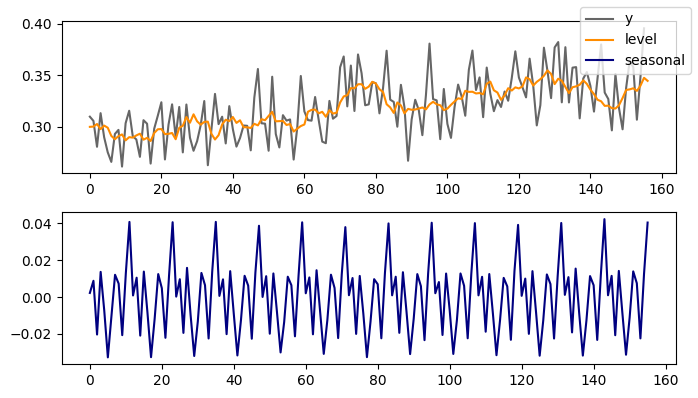

In [28]:
num_timesteps = 156
intervention_length=24
intervention_start = num_timesteps - intervention_length
burn_in = 13
plot_crop = 48

# Simulate Dataset
ll = local_level_seasonal(num_timesteps=num_timesteps, init_mu=.3, s_obs=.01, s_mu=.005, 
                          seasonality=12, s_seasonal=.001, seasonal_factor=.02, seeded=True, seed=4)
plot_local_level_seasonal(ll)

In [46]:
def intervention_interact_ll(sim, factor, impulse, decay):

    effect = factor

    sim_modified = get_intervention(sim, intervention_length=intervention_length, 
                                    s_weight=None, effect=effect, impulse=impulse,
                                    decay='normal')

    y_train = sim_modified['y_new'][:num_timesteps-intervention_length]

    model = sm.tsa.UnobservedComponents(y_train, level=True, stochastic_level=True, 
                                        seasonal=12, stochastic_seasonal=True
                                        )
    results = model.fit(disp=0)
    interval = get_predictions(results, forecast_length=intervention_length, burn_in=burn_in)
    int_begin = num_timesteps - burn_in - intervention_length
    plot_begin = int_begin - plot_crop
    plot_inference(sim_modified, interval, plot_begin, int_begin , burn_in=burn_in)

interact(
    intervention_interact_ll,
    sim= w.fixed(ll),
    factor = w.FloatSlider(value=-.3, min=-1.2, max=.0, step=.01),
    impulse = w.Dropdown(
                options=['static', 'return'],
                value='static'
            )
)

interactive(children=(FloatSlider(value=-0.3, description='factor', max=0.0, min=-1.2, step=0.01), Dropdown(de…

<function __main__.intervention_interact_ll(sim, factor, impulse)>

### Local Level Trend + Interventions

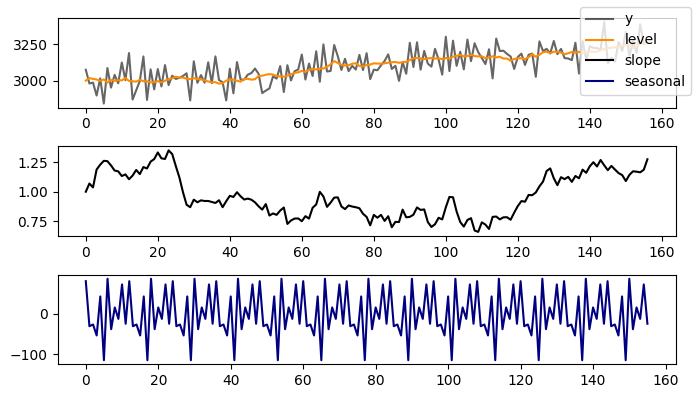

In [47]:
num_timesteps = 156
intervention_length=24
intervention_start = num_timesteps - intervention_length
burn_in = 13
init_delta=1
plot_crop = 48
init_mu = 3000
s_seasonal=.01
s_delta=.05
s_mu=10
s_obs=50
seasonal_factor=50

llt = local_level_trend_seasonal(num_timesteps, init_mu=init_mu, s_obs=s_obs, s_mu=s_mu, s_delta=s_delta, 
                                 init_delta=init_delta,  seasonality=12, s_seasonal=s_seasonal, 
                                 seasonal_factor=seasonal_factor, seeded=True, seed=1)
plot_level_trend_seasonal(llt)

### Effect Size Simulation

In [22]:
def intervention_interact_llt(sim, factor):
    """
    Takes one simulated dataset and applies an intervention that is variable with input
    Passes this to visulization of inference too see how well this structure captures the known difference
    And how much of a difference it can actually detect
    """

    effect = sim['y'][intervention_start] * factor

    sim_modified = get_intervention(sim, intervention_length=intervention_length, 
                                    s_weight=.01, effect=effect, impulse='return',
                                    decay='normal')

    y_train = sim_modified['y_new'][:num_timesteps-intervention_length]

    model = sm.tsa.UnobservedComponents(y_train, level=True, stochastic_level=True, trend=True, stochastic_trend=True, 
                                        seasonal=12, stochastic_seasonal=True, autoregressive=1)

    results = model.fit(disp=0)
    interval = get_predictions(results, forecast_length=intervention_length, burn_in=burn_in)
    int_begin = num_timesteps - burn_in - intervention_length
    plot_begin = int_begin - plot_crop
    plot_inference(sim_modified, interval, plot_begin, int_begin , burn_in=burn_in)

interact(
    intervention_interact_llt,
    sim= w.fixed(llt),
    factor = w.FloatSlider(value=-.18, min=-1.2, max=.0, step=.01)
)

interactive(children=(FloatSlider(value=-0.18, description='factor', max=0.0, min=-1.2, step=0.01), Output()),…

<function __main__.intervention_interact_llt(sim, factor)>